# ***Overview of the project***

1.   Assess the projected rate of EV adoption in California
2.   Assess the impact on electricity demand as a result of EV adoption
3.   Assess if the rate of deployment of EV charging stations meets the projected needs

The data necessary for this analysis is gathered from [State of California Data Catalog site](https://catalog.data.gov/dataset)

The data includes:


*   Light-duty vehicle sales data
*   Zero emission vehicle sales data
*   Electric charging stations data
*   Hydrogen refueling stations data





In [ ]:
# Import all necessary libraries necessary for the project

import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Load the source data gathered from https://www.energy.ca.gov/files/zev-and-infrastructure-stats-data
# Perform basic data cleanup

#Load Light-Duty Vehicle sales data
ldv_sales_df = pd.read_csv('/bin/data/LDV_Sales.csv')
ldv_sales_df.dropna(inplace=True)
print("Light-Duty Vehicle sales data")
#display(ldv_sales_df.info())
display(ldv_sales_df.head())
print("=========================================================================")

#Load Zero Emission Vehicle sales data
zev_sales_df = pd.read_csv('/bin/data/ZEV_Sales.csv')
zev_sales_df.dropna(inplace=True)
print("Zero Emission Vehicle sales data")
#display(zev_sales_df.info())
display(zev_sales_df.head())
print("=========================================================================")

#Load Electric Charging stations data
ev_chargers_df = pd.read_csv('/bin/data/EV_Chargers.csv')
ev_chargers_df.dropna(inplace=True)
ev_chargers_df = ev_chargers_df[ev_chargers_df['County'] != 'Total']
ev_chargers_df['Date'] = ev_chargers_df['Date'].astype(str).str.replace(r'(Q\d)\s*(\d{4})', r'\2\1', regex=True)
print("Electric Charging stations data")
#display(ev_chargers_df.info())
display(ev_chargers_df.head())
print("=========================================================================")

#Load Hydrogen Refueling stations data
hrs_df = pd.read_csv('/bin/data/Hydrogen_Refueling_Stations.csv')
hrs_df.dropna(inplace=True)
hrs_df = hrs_df.drop(['Latitude', 'Longitude'], axis=1)
print("Hydrogen Refueling stations data")
#display(hrs_df.info())
display(hrs_df.head())
print("=========================================================================")

Light-Duty Vehicle sales data


,Data Year,Quarter,COUNTY,ZEV Sales,Total LDV Sales,ZEV Sales Share
0,2025,1,Alameda,5525,14812,37%
1,2025,1,Alpine,0,3,0%
2,2025,1,Amador,31,234,13%
3,2025,1,Butte,118,1109,11%
4,2025,1,Calaveras,38,311,12%


Zero Emission Vehicle sales data


,Data Year,Quarter,COUNTY,FUEL_TYPE,MAKE,MODEL,Number of Vehicles
0,2008,3,Alameda,Electric,Tesla,Roadster,1
1,2008,3,San Francisco,Electric,Tesla,Roadster,1
2,2008,3,San Mateo,Electric,Tesla,Roadster,3
3,2008,3,Santa Clara,Electric,Tesla,Roadster,4
4,2008,3,Sonoma,Electric,Tesla,Roadster,1


Electric Charging stations data


,County,Public Level 1,Shared Private Level 1,Public Level 2,Shared Private Level 2,Public DC Fast,Shared Private DC Fast,Total,Date
0,Alameda,4.0,72.0,2622.0,4040.0,898.0,102.0,7738.0,2025Q1
1,Alpine,0.0,0.0,20.0,2.0,0.0,0.0,22.0,2025Q1
2,Amador,0.0,0.0,55.0,4.0,8.0,0.0,67.0,2025Q1
3,Butte,0.0,0.0,175.0,99.0,41.0,0.0,315.0,2025Q1
4,Calaveras,0.0,2.0,19.0,6.0,21.0,0.0,48.0,2025Q1


Hydrogen Refueling stations data


,Station Number,Station Name,Open Retail Status,Address,City,State,Zip Code,County,Number of Stations,Fueling Positions
0,1,Diamond Bar,Light-Duty Open Retail,21865 E. Copley Drive,Diamond Bar,CA,91765,Los Angeles,1,1
1,2,West Sacramento,Light-Duty Open Retail,1515 S. River Road,West Sacramento,CA,95691,Yolo,1,2
2,3,San Juan Capistrano,Light-Duty Open Retail,26572 Junipero Serra Rd.,San Juan Capistrano,CA,92675,Orange,1,2
3,4,Fairfax,Light-Duty Open Retail,7751 Beverly Blvd.,Los Angeles,CA,90036,Los Angeles,1,1
4,5,Lawndale,Light-Duty Open Retail,15606 Inglewood Ave.,Lawndale,CA,90260,Los Angeles,1,1


# **Observation**

Based on the initial analysis, the data seems be to pretty clean and good to proceed for initial analysis.  If necessary we will come back to clean-up or create any necessary feields as necessary.

,Data Year,Quarter,Total LDV Sales,ZEV Sales,YearQuarter
YearQuarter,,,,,
2008Q1,2008,1,191811,0,2008Q1
2008Q2,2008,2,217078,0,2008Q2
2008Q3,2008,3,204652,10,2008Q3
2008Q4,2008,4,155737,65,2008Q4
2009Q1,2009,1,139711,51,2009Q1


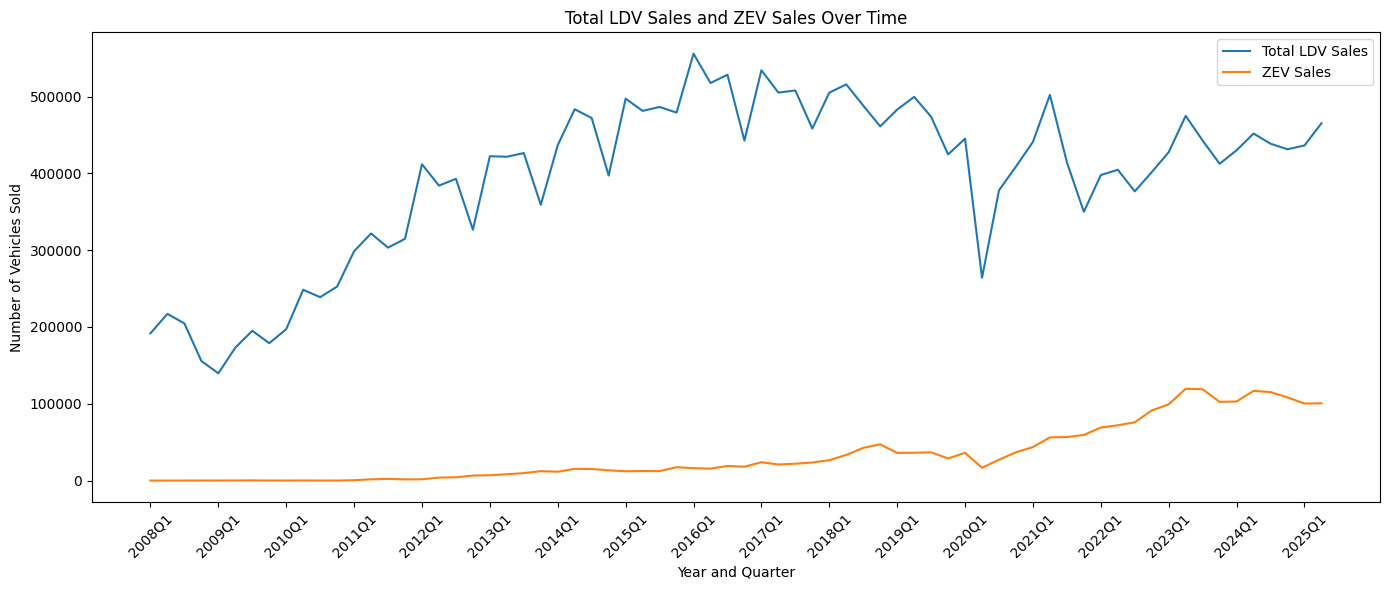

In [ ]:
# Prepare and plot the Total car sales vs Zero-emission car sales -- Start

sales_by_quarter = ldv_sales_df.groupby(['Data Year', 'Quarter'])[['Total LDV Sales', 'ZEV Sales']].sum().reset_index()
#display(sales_by_quarter.head())

#Use the YearQuarter as the new index, beneficial for plotting
sales_by_quarter['YearQuarter'] = sales_by_quarter['Data Year'].astype(str) + 'Q' + sales_by_quarter['Quarter'].astype(str)
sales_by_quarter.index = pd.PeriodIndex(sales_by_quarter['YearQuarter'], freq='Q')
display(sales_by_quarter.head())

# Set appropriate charting labels
plt.figure(figsize=(14, 6))
plt.plot(sales_by_quarter.index.astype(str), sales_by_quarter['Total LDV Sales'], label='Total LDV Sales')
plt.plot(sales_by_quarter.index.astype(str), sales_by_quarter['ZEV Sales'], label='ZEV Sales')
plt.xlabel('Year and Quarter')
plt.ylabel('Number of Vehicles Sold')
plt.title('Total LDV Sales and ZEV Sales Over Time')
plt.legend()
plt.xticks(sales_by_quarter.index.astype(str)[::4], rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
# Prepare and plot the Total car sales vs Zero-emission car sales -- End

# **Observation**

Based on the simple plot of vehicle sales of ICE (Internal combustion Engine) vs. ZEV (Zero Emission Vehicles), seems like ZEV have a long way to go.  We need approximately 3x - 4x the sales of current ZEV sold to just to catchup and meet the current demands.

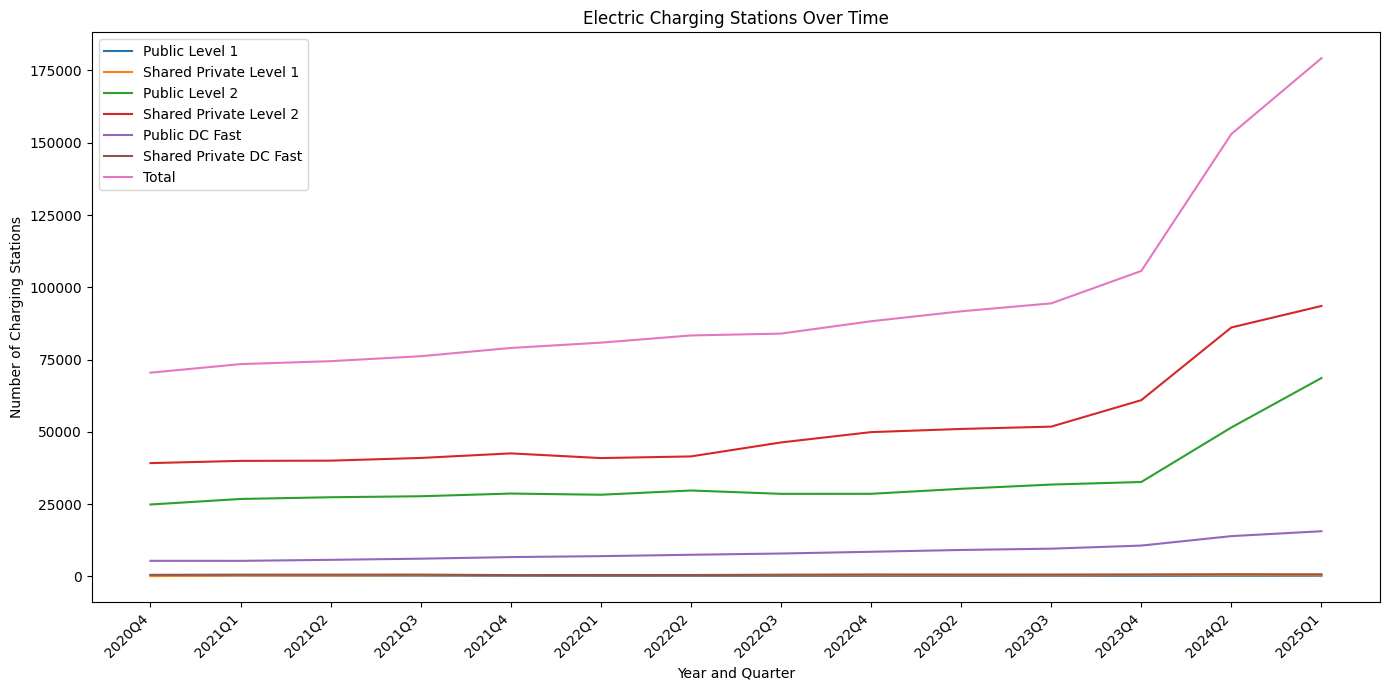

In [ ]:
# Convert the 'Date' column to a proper time series format (e.g., Period) for plotting
ev_chargers_df['Date_Period'] = pd.PeriodIndex(ev_chargers_df['Date'], freq='Q')

# Group by Date and sum the charging station types and total
charging_over_time = ev_chargers_df.groupby('Date_Period')[['Public Level 1', 'Shared Private Level 1', 'Public Level 2', 'Shared Private Level 2', 'Public DC Fast', 'Shared Private DC Fast', 'Total']].sum().reset_index()

# Plot the data
plt.figure(figsize=(14, 7))

for column in ['Public Level 1', 'Shared Private Level 1', 'Public Level 2', 'Shared Private Level 2', 'Public DC Fast', 'Shared Private DC Fast', 'Total']:
    plt.plot(charging_over_time['Date_Period'].astype(str), charging_over_time[column], label=column)

plt.xlabel('Year and Quarter')
plt.ylabel('Number of Charging Stations')
plt.title('Electric Charging Stations Over Time')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# **Observation**

Based on the above chat, looks like the deployment of number of electric charging stations have picked up in the past couple of years and this will need to continue if the expected sales of ZEV is grow at 3x - 4x pace.

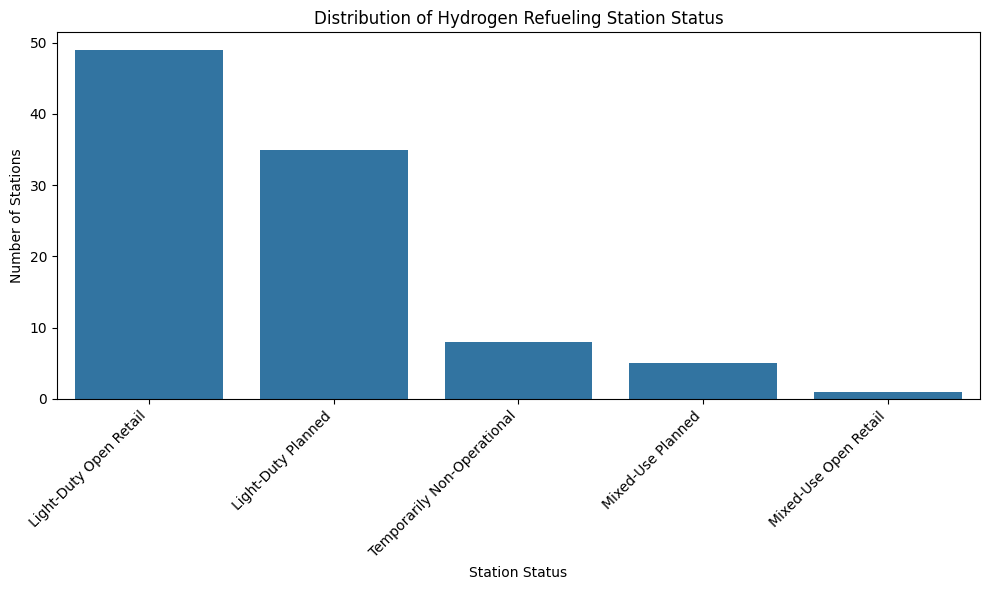

In [ ]:
# Plot hydrogen fueling stations data

status_counts = hrs_df['Open Retail Status'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=status_counts.index, y=status_counts.values)
plt.xlabel('Station Status')
plt.ylabel('Number of Stations')
plt.title('Distribution of Hydrogen Refueling Station Status')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

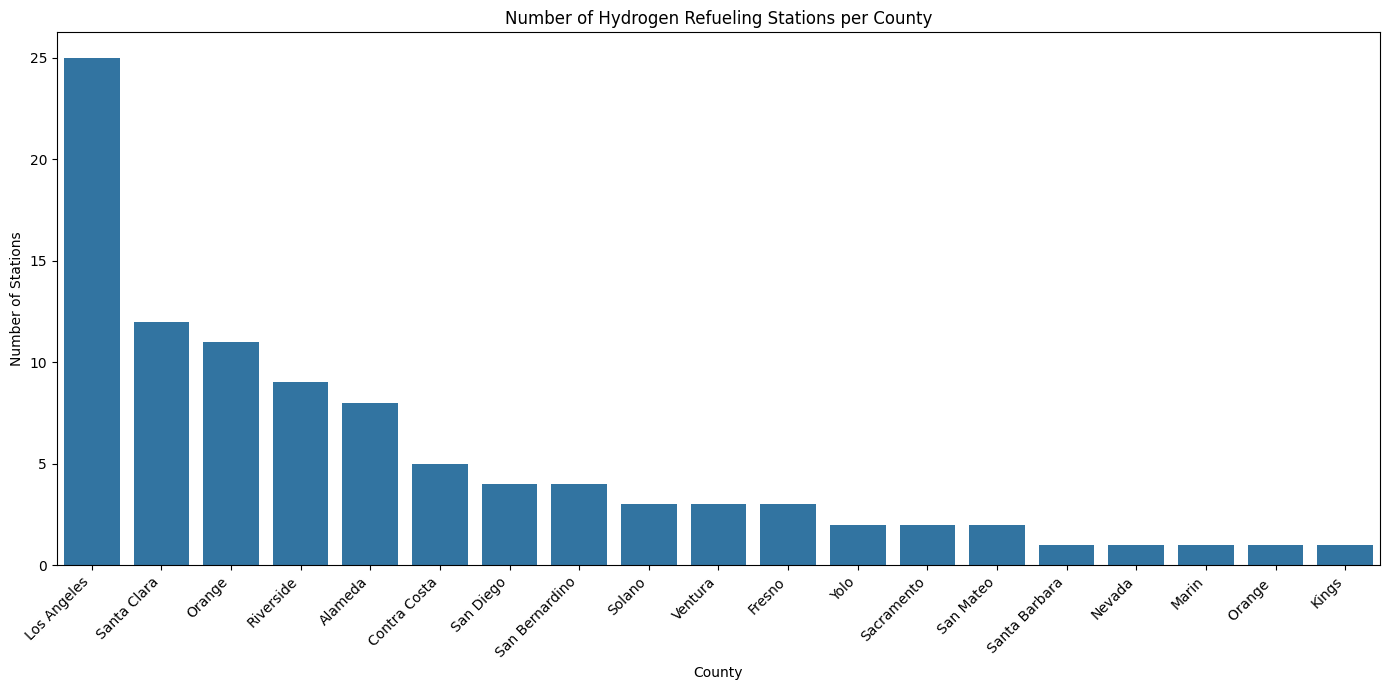

In [ ]:
#Plot to visualize hydrogen refueling stations in each county

county_counts = hrs_df['County'].value_counts()
plt.figure(figsize=(14, 7))
sns.barplot(x=county_counts.index, y=county_counts.values)
plt.xlabel('County')
plt.ylabel('Number of Stations')
plt.title('Number of Hydrogen Refueling Stations per County')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# **Observation**

Based on the hydrogen station deployment, it looks like this will need significant increase in deployment

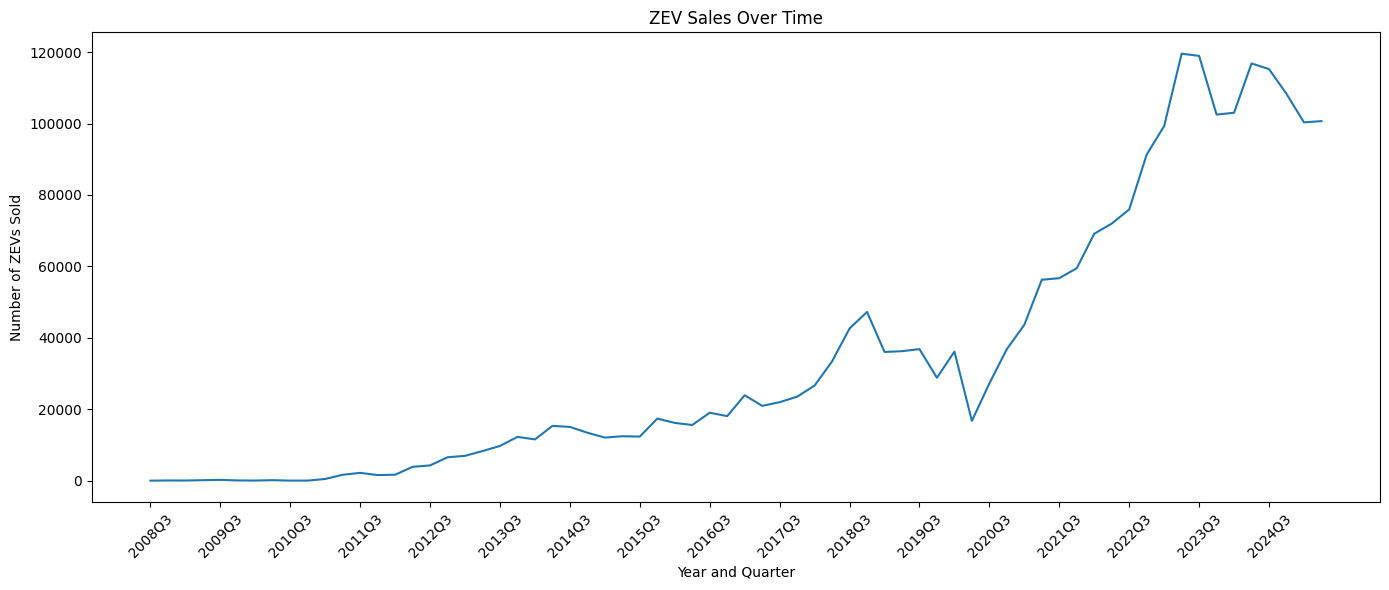

In [ ]:
#Plot to visualize Zero-Emission Vehicle sales over time

zev_sales_by_quarter = zev_sales_df.groupby(['Data Year', 'Quarter'])['Number of Vehicles'].sum().reset_index()

zev_sales_by_quarter['YearQuarter'] = zev_sales_by_quarter['Data Year'].astype(str) + 'Q' + zev_sales_by_quarter['Quarter'].astype(str)
zev_sales_by_quarter.index = pd.PeriodIndex(zev_sales_by_quarter['YearQuarter'], freq='Q')

plt.figure(figsize=(14, 6))
plt.plot(zev_sales_by_quarter.index.astype(str), zev_sales_by_quarter['Number of Vehicles'])
plt.xlabel('Year and Quarter')
plt.ylabel('Number of ZEVs Sold')
plt.title('ZEV Sales Over Time')
plt.xticks(zev_sales_by_quarter.index.astype(str)[::4], rotation=45)
plt.tight_layout()
plt.show()

# **Observation**

Based on the ZEV historic vehicles sales data, seems like the sales have stalled over the past few years.  A little more analysis is necessary to identify is this is just a problem with the data or is it a result of some of the current policies.

As mentioned earlier if the ZEV is to replace ICE vehicles sales, then this is certainly a concern.

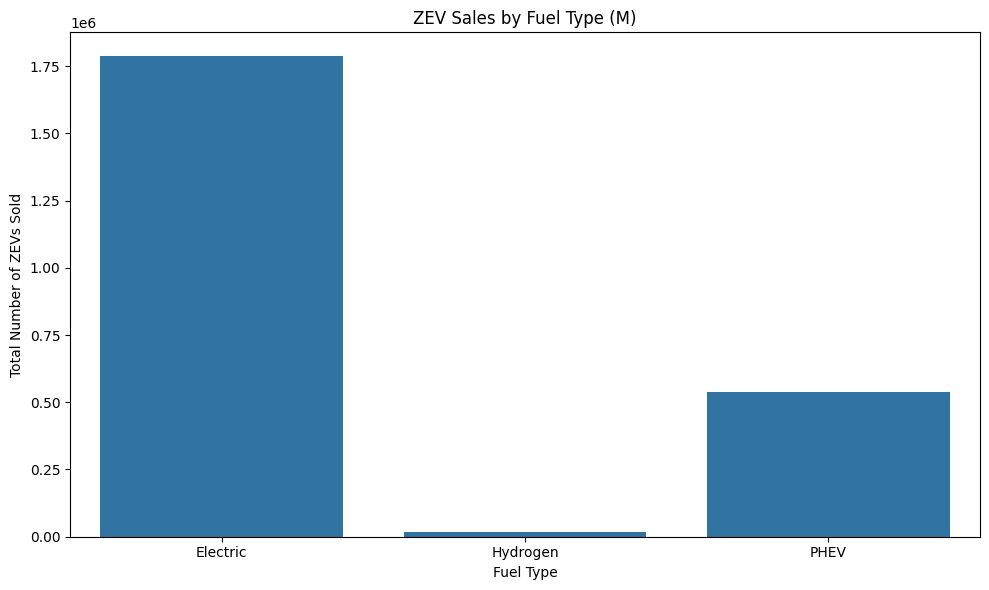

In [ ]:
#Visualize the distribution of ZEV sales across different fuel types (Electric, PHEV, etc.).

fuel_type_counts = zev_sales_df.groupby('FUEL_TYPE')['Number of Vehicles'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='FUEL_TYPE', y='Number of Vehicles', data=fuel_type_counts)
plt.xlabel('Fuel Type')
plt.ylabel('Total Number of ZEVs Sold')
plt.title('ZEV Sales by Fuel Type (M)')
plt.tight_layout()
plt.show()

# **Observation**

As expected, this clearly indicates the most popular vehicle type in the ZEV category is Fully Electric vehicles.  The second best

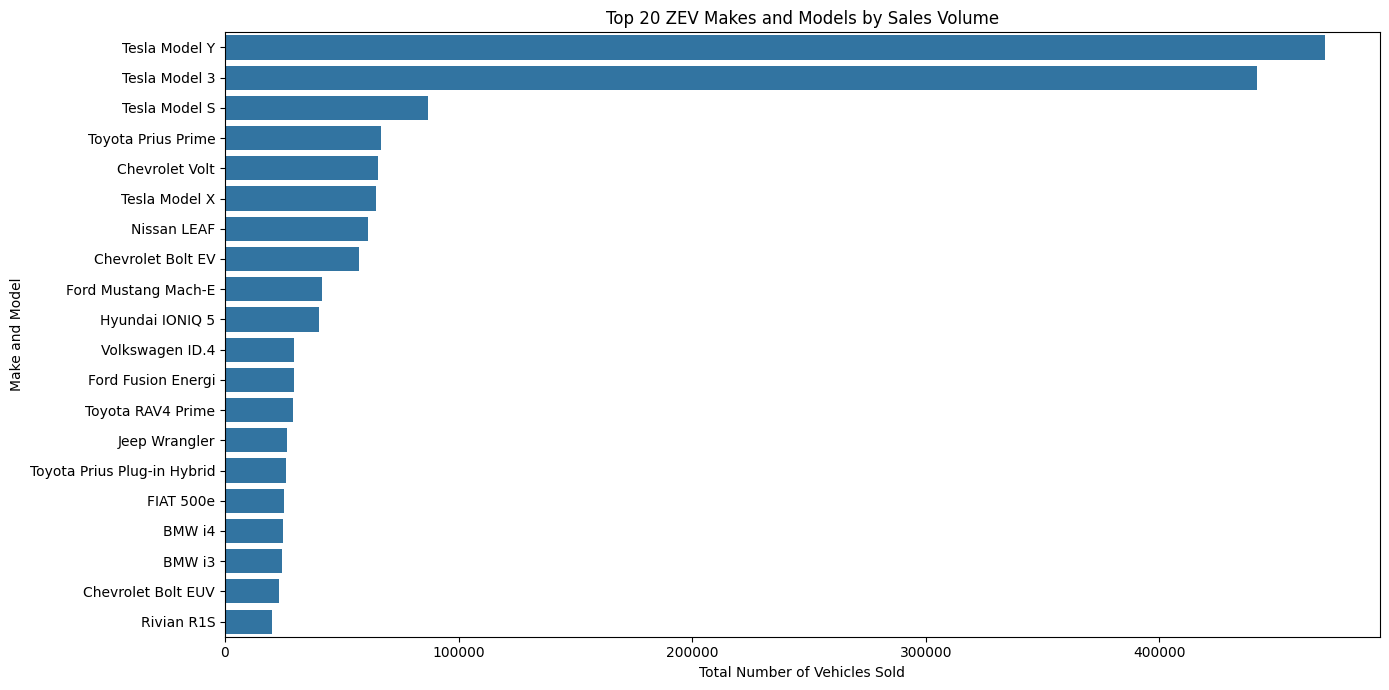

In [ ]:
# Explore the top ZEV makes and models by sales volume.
# Group the zev_sales_df DataFrame by 'MAKE' and 'MODEL

make_model_sales = zev_sales_df.groupby(['MAKE', 'MODEL'])['Number of Vehicles'].sum().reset_index()
top_make_models = make_model_sales.sort_values(by='Number of Vehicles', ascending=False).head(20)

plt.figure(figsize=(14, 7))
sns.barplot(x='Number of Vehicles', y=top_make_models['MAKE'] + ' ' + top_make_models['MODEL'], data=top_make_models)
plt.xlabel('Total Number of Vehicles Sold')
plt.ylabel('Make and Model')
plt.title('Top 20 ZEV Makes and Models by Sales Volume')
plt.tight_layout()
plt.show()

# **Observation**

Again, clearly not a surprse the most popular vehicle sold (in-fact the top 3) are Tesla.  Infact the top 2 are close to 5 times the sales of any other vehicle type sold.

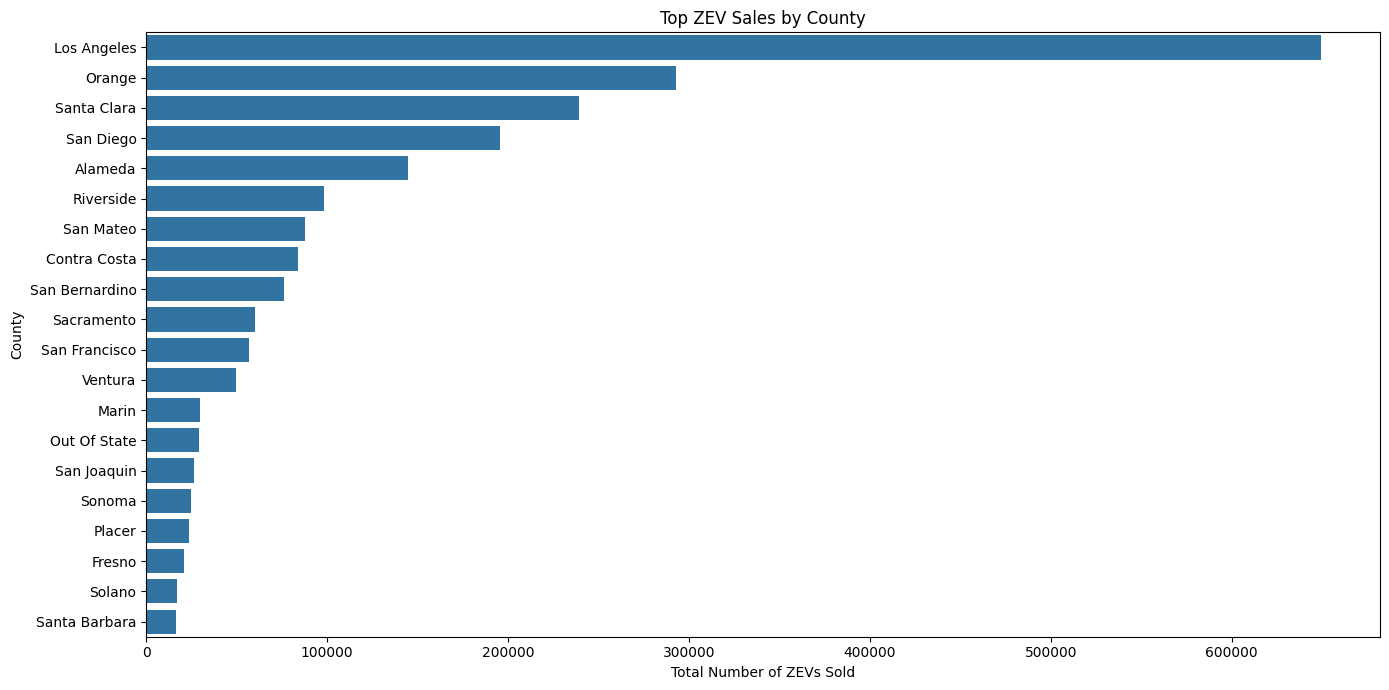

In [ ]:
#Visualize the geographical distribution of ZEV sales across different counties.

county_zev_sales = zev_sales_df.groupby('COUNTY')['Number of Vehicles'].sum().reset_index()
county_zev_sales_sorted = county_zev_sales.sort_values(by='Number of Vehicles', ascending=False)
top_20_counties = county_zev_sales_sorted.head(20)

plt.figure(figsize=(14, 7))
sns.barplot(x='Number of Vehicles', y='COUNTY', data=top_20_counties)
plt.xlabel('Total Number of ZEVs Sold')
plt.ylabel('County')
plt.title('Top ZEV Sales by County')
plt.tight_layout()
plt.show()

# **Observation**

This just shows the distribution of vechiles sold and the top few cities in california.

In [ ]:
# Since the task is to predict sales volume, a regression model is more appropriate.
# A simple Linear Regression model should serve as a baseline.

# For demonstration, let's use 'Data Year' to predict 'Number of Vehicles'
X = zev_sales_df[['Data Year']]
y = zev_sales_df['Number of Vehicles']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Evaluate the model (using R-squared as a simple metric)
r_squared = baseline_model.score(X_test, y_test)
print(f"Baseline Linear Regression Model R-squared: {r_squared}")

# Make predictions on the test set
y_pred = baseline_model.predict(X_test)

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

# This can now serve as the 'baseline_model' for comparison with other more complex models for analysis.

Baseline Linear Regression Model R-squared: 0.0004936251325029506
Mean Absolute Error (MAE): 49.04106058835914
Mean Squared Error (MSE): 35749.20883963423
Root Mean Squared Error (RMSE): 189.07461183256262
R-squared: 0.0004936251325029506


# **Interpretation of evaluation metrics**

***R-squared***: Represents the variance in the dependent variable (ZEV Sales) that is predictable from the independent variable (Data Year).  The low value in this case indicates that 'Year' alone is not a good fit and is a poor predictor of ZEV sales.

***Mean Absolute Error***: The average of the absolute differences between the actual and predicted values.  This simple metric indicates the average model's predictions for ZEV sales are off by approximately 49 vehicles.

***Mean Squared Error***: The average of the squared differences between the actual and predicted values.  The high values indicates larger prediction errors, as this model penalizes larger more heavely as the errors are squared.

***Root Mean Squared Error***: The square root of the Mean Squared Error.  This metric indicates the average model's predictions for ZEV sales are off by approximately 189 vehicles.  This is much higher than MAE, further indicating larger errors in the model prediction.